In [20]:
import torch
from model import FaceDetector
import matplotlib.pyplot as plt
from loss_multiface import Yolo_Loss
from full_face_dataset import FullFaceDataset
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from nonmax_suppression import non_max_supp

In [21]:
model = FaceDetector(dropout=0.5)

In [22]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [23]:
TRAIN_CSV_PATH = '/home/kuba/Documents/data/raw/face-detection-dataset/train.csv'
TRAIN_IMG_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/images/train'
TRAIN_LABELS_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/labels/train' 
full_dataset = FullFaceDataset(TRAIN_CSV_PATH, TRAIN_IMG_DIR, TRAIN_LABELS_DIR)

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=10)
# scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.01)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[100])
criterion = Yolo_Loss()

/home/kuba/.virenv/base/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [25]:
len(full_dataset)

13386

In [26]:
train_indices = list(range(12000))
dev_indices = list(range(12000, len(full_dataset)))

# Create Subset datasets
train_dataset = Subset(full_dataset, train_indices)
dev_dataset = Subset(full_dataset, dev_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64)
dev_loader = DataLoader(dev_dataset, batch_size=64)

In [27]:
lossi = []
dev_lossi = []

In [28]:
device = 'cuda:1'
model = model.to(device)

In [29]:
for epoch in tqdm(range(20)):
    loss_total = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    lossi.append(loss_total / len(train_loader))

    dev_loss_total = 0
    model.eval()
    with torch.no_grad():
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device)
            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev)
            dev_loss_total += dev_loss.item()
    dev_lossi.append(dev_loss_total/ len(dev_loader))

    # scheduler.step()

100%|██████████| 20/20 [41:36<00:00, 124.83s/it]


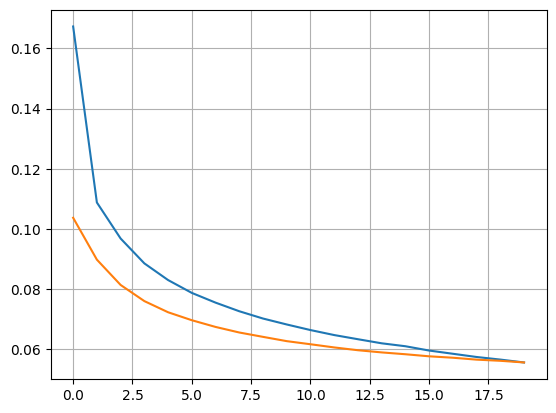

In [37]:
plt.plot(lossi)
plt.plot(dev_lossi)
plt.grid(True)

In [31]:
dev_logits = dev_logits.view((-1, 7, 7, 10))
dev_logits.shape

torch.Size([42, 7, 7, 10])

In [58]:
post_non_max = non_max_supp(dev_logits.detach().cpu(), iou_threshold=0.15)

In [59]:
def plot_post_non_max(img, preds, preds_type='cx,cy,w,h', labels=[], labels_type='cx,cy,w,h'):
    img = img.permute(1, 2, 0) #to go from (3 x W x H) to (W x H x 3)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    img_w, img_h = img.shape[:2]

    def plot_cxcywh_style(labels, img_w, img_h, color, marker='ro', show_confidance=False):
         for label in labels:
            confidance, center_x, center_y, width, height = label
            center_x, center_y, width, height = int(center_x * img_w), int(center_y * img_h), int(width * img_w), int(height * img_h)
            xmin = center_x - width/2
            xmax = center_x + width/2
            ymin = center_y - height/2
            ymax = center_y + height/2
            
            #  center and text
            if show_confidance:
                plt.text(center_x, center_y, f"{confidance.item():.3f}", bbox=dict(facecolor='white', alpha=0.35, boxstyle='round'), fontsize=8)
            plt.plot(center_x, center_y, marker)

            
            # (horizontal lines)
            plt.hlines(ymin, xmin=xmin, xmax=xmax, colors=color)
            plt.hlines(ymax, xmin=xmin, xmax=xmax, colors=color)
            
            # (vertical lines)
            plt.vlines(xmin, ymin=ymin, ymax=ymax, colors=color)
            plt.vlines(xmax, ymin=ymin, ymax=ymax, colors=color)
         

    if preds_type == 'cx,cy,w,h':
        plot_cxcywh_style(preds, img_w, img_h, 'red', 'ro', True)

    if len(labels) != 0 and labels_type == 'cx,cy,w,h':
        plot_cxcywh_style(labels, img_w, img_h, 'green', 'g1')
    
    plt.axis('off')
    plt.show()

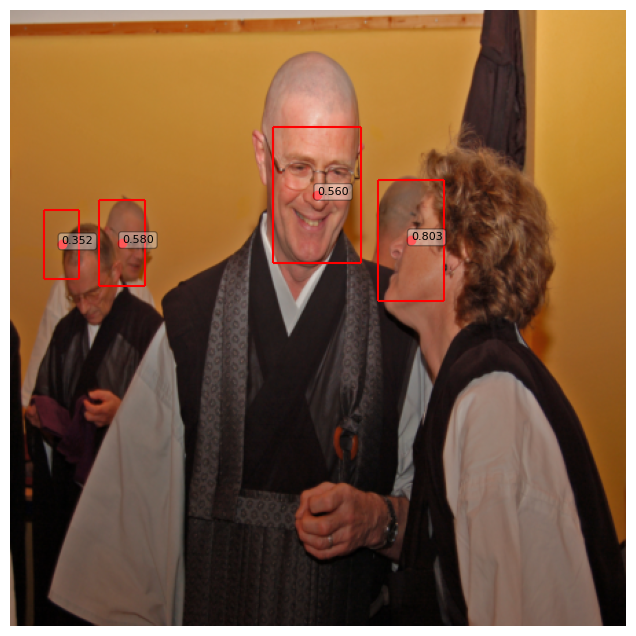

In [100]:
img_num = 26
plot_post_non_max(X_dev[img_num].cpu(), post_non_max[img_num])

In [90]:
torch.save(model.state_dict(), "best_dev_loss.pth")

In [88]:
import json
with open("metrics.json", "w") as file:
    json.dump({"lossi":lossi, "devlossi":dev_lossi}, file)

In [91]:
torch.save(optimizer.state_dict(), "optim_dict_best_dev_loss.pth")
